# Evaluation and analysis

### Setting paths and environment variables:

In [1]:
import os

os.chdir('..')

In [2]:
os.getcwd()

'/home/ander/PycharmProjects/nnunet-ms-segmentation'

### Generic:

In [3]:
import os
from custom_scripts.A_config import (
    ROOT,
    TEST_IMAGES_DIR,
    TEST_LABELS_DIR,
    NNUNET_TEST_RESULTS_PATH,
    TERMINATION,
    DATASET,
    CONFIGURATION,
    PLAN
)

### Specific:

In [15]:
TRAINER = "nnUNetTrainerFullOversamplingEarlyStopping"

In [16]:
ALL_TEST_PREDICTIONS_FOLDER = os.path.join(ROOT, 'nnUNet_test_results')
TEST_SPECIFIC_FOLDER_NAME = TRAINER + '__' + PLAN + "__" + CONFIGURATION
TEST_PREDICTIONS_FOLDER = os.path.join(ALL_TEST_PREDICTIONS_FOLDER, DATASET, TEST_SPECIFIC_FOLDER_NAME)

## Analysing specific cases:

In [17]:
import custom_scripts.F_evaluate_quantitative as equant

In [18]:
equant.TEST_PREDICTIONS_FOLDER = TEST_PREDICTIONS_FOLDER

In [19]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

In [20]:
test_images = os.listdir(TEST_IMAGES_DIR)
test_ids = sorted({file_name.split(".")[0][:-5] for file_name in test_images})

In [22]:
sample_case_num_idx = 7  # or sample from range(len(test_ids))
sample_case_id = test_ids[sample_case_num_idx]
sample_labels_path, sample_predictions_path = equant.get_paths(case_id=sample_case_id, labels=True, preds=True)

In [23]:
from nnunetv2.imageio.simpleitk_reader_writer import SimpleITKIO
from nnunetv2.evaluation.evaluate_predictions import compute_metrics

results = compute_metrics(
    reference_file=sample_labels_path,
    prediction_file=sample_predictions_path,
    image_reader_writer=SimpleITKIO(),
    labels_or_regions=[1, 2]
)

In [24]:
results

{'reference_file': '/home/ander/PycharmProjects/nnunet-ms-segmentation/data/nnUNet_raw_data/Dataset100_MSSEG/labelsTs/FIS_039_01.nii.gz',
 'prediction_file': '/home/ander/PycharmProjects/nnunet-ms-segmentation/nnUNet_test_results/Dataset100_MSSEG/nnUNetTrainerFullOversamplingEarlyStopping__nnUNetPlans__3d_fullres/FIS_039_01.nii.gz',
 'metrics': {1: {'Dice': 0.8189320745592363,
   'IoU': 0.6933827063787363,
   'FP': 5304,
   'TP': 38948,
   'FN': 11919,
   'TN': 7164861,
   'n_pred': 44252,
   'n_ref': 50867},
  2: {'Dice': 0.24210526315789474,
   'IoU': 0.1377245508982036,
   'FP': 0,
   'TP': 23,
   'FN': 144,
   'TN': 7220865,
   'n_pred': 23,
   'n_ref': 167}}}

In [25]:
sample_b_image, sample_fu_image = equant.read_images(case_id=sample_case_id)
sample_labels, sample_predictions = equant.read_labels_and_preds(case_id=sample_case_id)

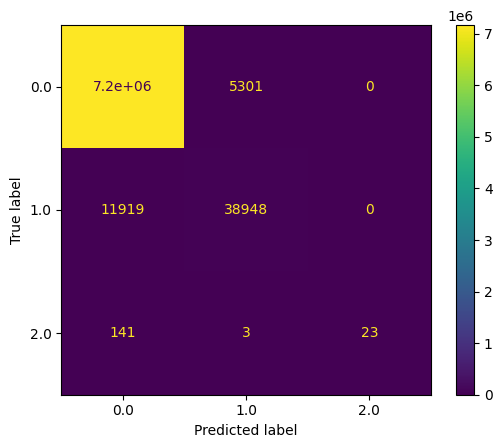

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_true=sample_labels.flatten(), y_pred=sample_predictions.flatten())

In [28]:
sample_b_image_path, sample_fu_image_path = equant.get_paths(case_id=sample_case_id, basal_im=True, follow_up_im=True)
raw_sample_b_image = nib.load(sample_b_image_path)

In [29]:
print(raw_sample_b_image)


<class 'nibabel.nifti1.Nifti1Image'>
data shape (182, 218, 182)
affine:
[[  -1.    0.    0.   90.]
 [   0.    1.    0. -126.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 182 218 182   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.  1.  1.  1.  0.  0.  0.  0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'6.0.5:9e026117'
aux_file        : b''
qform_code      : m

In [30]:
nib.aff2axcodes(raw_sample_b_image.affine)

('L', 'A', 'S')

[La orientación de los vóxeles es](https://github.com/eloydelas/lesion-segmentation-challenge-miccai21/blob/main/TFM_Implementacion.ipynb):

+ El primer eje va de derecha a izquierda (plano sagital);
+ El segundo eje va de detrás a adelante (plano coronal);
+ El tercer eje va de inferior a superior (plano axial).

In [31]:
IMAGES_SHAPE = sample_b_image.shape

### Visualizaciones de las imágenes:

In [32]:
masked_basal_lesions = np.ma.masked_where(sample_labels != 1, sample_labels)

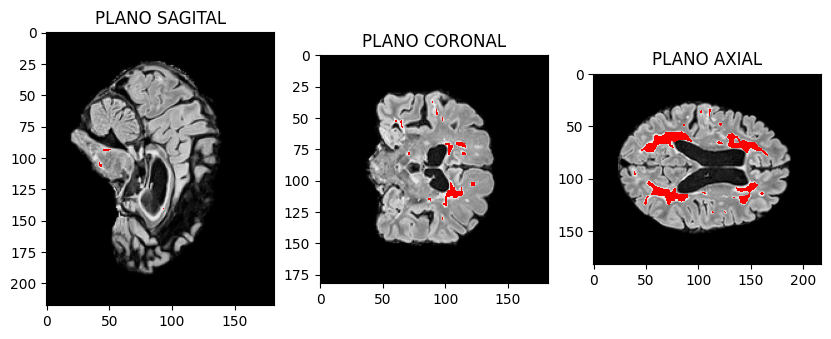

In [33]:
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(10, 12))
_ = axis1.imshow(sample_b_image[IMAGES_SHAPE[0] // 2, :, :], cmap='gray')
_ = axis1.imshow(masked_basal_lesions[IMAGES_SHAPE[0] // 2, :, :], cmap='autumn')
axis1.set_title('PLANO SAGITAL')
_ = axis2.imshow(sample_b_image[:, IMAGES_SHAPE[1] // 2, :], cmap='gray')
_ = axis2.imshow(masked_basal_lesions[:, IMAGES_SHAPE[1] // 2, :], cmap='autumn')
axis2.set_title('PLANO CORONAL')
_ = axis3.imshow(sample_b_image[:, :, IMAGES_SHAPE[2] // 2], cmap='gray')
_ = axis3.imshow(masked_basal_lesions[:, :, IMAGES_SHAPE[2] // 2], cmap='autumn')
axis3.set_title('PLANO AXIAL');

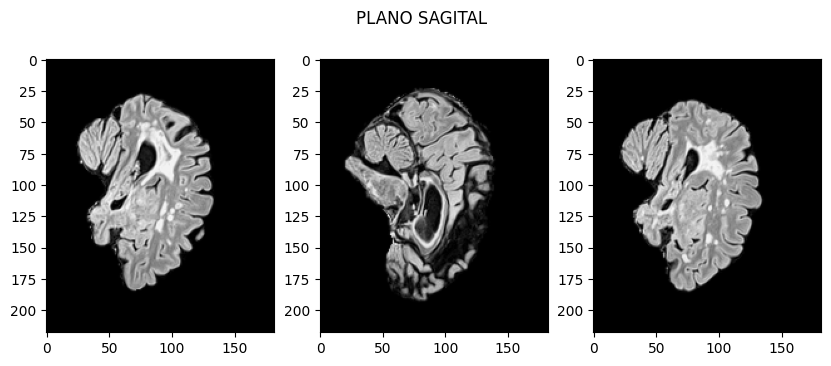

In [34]:
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(10, 12))
_ = axis1.imshow(sample_b_image[IMAGES_SHAPE[0] // 3, :, :], cmap='gray')
_ = axis2.imshow(sample_b_image[IMAGES_SHAPE[0] // 2, :, :], cmap='gray')
_ = axis3.imshow(sample_b_image[IMAGES_SHAPE[0] * 2 // 3, :, :], cmap='gray')
fig.suptitle('PLANO SAGITAL', y=0.65);

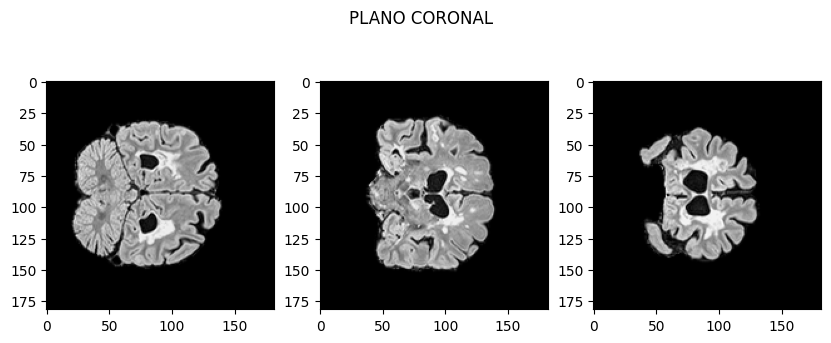

In [35]:
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(10, 12))
_ = axis1.imshow(sample_b_image[:, IMAGES_SHAPE[1] // 3, :], cmap='gray')
_ = axis2.imshow(sample_b_image[:, IMAGES_SHAPE[1] // 2, :], cmap='gray')
_ = axis3.imshow(sample_b_image[:, IMAGES_SHAPE[1] * 2 // 3, :], cmap='gray')
fig.suptitle('PLANO CORONAL', y=0.65);

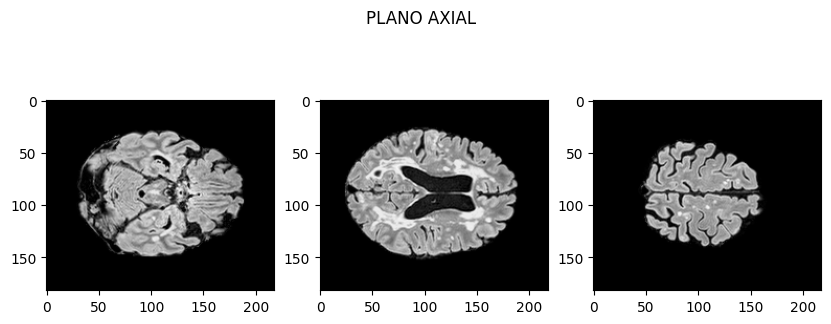

In [36]:
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(10, 12))
_ = axis1.imshow(sample_b_image[:, :, IMAGES_SHAPE[2] // 3], cmap='gray')
_ = axis2.imshow(sample_b_image[:, :, IMAGES_SHAPE[2] // 2], cmap='gray')
_ = axis3.imshow(sample_b_image[:, :, IMAGES_SHAPE[2] * 2 // 3], cmap='gray')
fig.suptitle('PLANO AXIAL', y=0.65);